In [4]:
import json
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns

def load_yaml(fname):
    with open(fname, 'r') as stream:
        try:
            f = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
            sys.exit(1)
    return f

In [2]:
os.chdir('..')
wordfreq = './datasets/wiki/wordfreq.json'
with open(wordfreq, 'r') as f:
    wf = json.load(f)

settings = load_yaml("settings.yaml")
    
path = settings["ASSIN"]["path"]
fnames = list(settings["ASSIN"]["files"]["ptbr"].values()) + list(settings["ASSIN"]["files"]["pteu"].values())

words = []
for name in fnames:
    with open(path + name) as f:
        data = json.load(f)
        for item in data:
            words.extend(item['t'])
            words.extend(item['h'])

frequencies = [ wf.get(word,0) for word in words ]

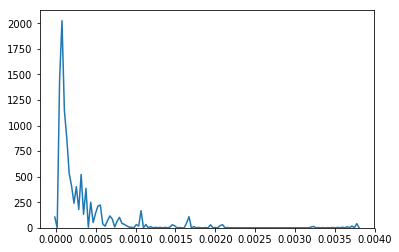

In [30]:
#sns.distplot(frequencies,hist=False, bins=10);
total = sum(wf.values())
sns.distplot([ x/total for x in frequencies ],hist=False, bins=10)

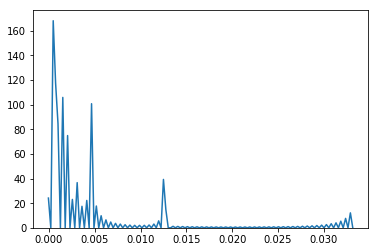

In [28]:
from wordfreq import word_frequency
lib_frequencies = [ word_frequency(word, 'pt', wordlist='best', minimum=0.0) for word in words ]
sns.distplot(lib_frequencies,hist=False, bins=10)

In [10]:
with open('hartmann_results.txt') as f:
    table = f.read().split('\n')

hartmann_results = []
for item in table:
    line = item.split(' ')
    line = list(filter(lambda x: len(x), line))
    if not line:
        continue
    row = {
        'model': line[0],
        'ptbr-pearson-2017': line[1],
        'ptbr-MSE-2017': line[2],
        'pteu-pearson-2017': line[3],
        'pteu-MSE-2017': line[4]
    }
    hartmann_results.append(row)

    
df2017 = pd.DataFrame(hartmann_results)

df2017

,model,ptbr-MSE-2017,ptbr-pearson-2017,pteu-MSE-2017,pteu-pearson-2017
0,fasttext_cbow_s50,0.66,0.36,1.05,0.34
1,fasttext_cbow_s100,0.66,0.37,1.04,0.36
2,fasttext_cbow_s300,0.65,0.38,1.03,0.37
3,fasttext_cbow_s600,0.68,0.33,1.02,0.38
4,fasttext_cbow_s1000,0.64,0.39,0.99,0.41
5,fasttext_skip_s50,0.61,0.45,0.98,0.43
6,fasttext_skip_s100,0.58,0.49,0.94,0.47
7,fasttext_skip_s300,0.53,0.55,1.02,0.40
8,fasttext_skip_s600,0.64,0.40,1.01,0.40
9,fasttext_skip_s1000,0.56,0.52,0.86,0.54


In [11]:
df2019_no_elmo = df2019[df2019.model != 'ELMo']
df = pd.merge(df2017, df2019_no_elmo, how='outer', on='model')
df = df.drop(['pteu-MSE-2017', 'pteu-pearson-2017'], axis=1)
df = df.rename(columns={"MSE": "ptbr-MSE-2019", "pearson": "ptbr-pearson-2019"})

cols = df.columns.tolist()
cols = [cols[1], cols[3]]
tmp = df[cols]
df['diff'] = pd.to_numeric(df['ptbr-MSE-2017']).sub(df['ptbr-MSE-2019'], axis=0)

mean = df['diff'].values.astype(float).mean()
Q1 = df['diff'].quantile(0.25)
Q3 = df['diff'].quantile(0.75)
IQR = Q3 - Q1

elmo_row = df2019[df2019['model'] == 'ELMo'].to_dict()
elmo = {}
elmo['ptbr-MSE-2019'] = elmo_row['MSE'][0]
elmo['ptbr-pearson-2019'] = elmo_row['pearson'][0]
elmo['model'] = 'ELMo'
df = df.append(elmo, ignore_index=True)

def highlight_outliers(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return [attr if v else '' for v in is_out]
    else: 
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return pd.DataFrame(np.where(is_out, attr, ''),
                            index=data.index, columns=data.columns)
   
style_df = df.style.apply(highlight_outliers, color='darkorange', axis=None, subset=['diff'])

In [20]:
df = df.sort_values(by='ptbr-MSE-2019')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_ptbr-MSE-2019.xlsx")
style_df

,model,ptbr-MSE-2017,ptbr-pearson-2017,ptbr-MSE-2019,ptbr-pearson-2019,diff
9,fasttext_skip_s1000,0.56,0.52,0.491466,0.595615,0.0685345
19,wang2vec_skip_s1000,0.49,0.60,0.492201,0.594679,-0.00220142
8,fasttext_skip_s600,0.64,0.40,0.49444,0.591606,0.14556
18,wang2vec_skip_s600,0.49,0.59,0.497738,0.588351,-0.00773769
35,ELMo,nan,nan,0.497809,0.58791,nan
7,fasttext_skip_s300,0.53,0.55,0.500397,0.58479,0.0296034
29,word2vec_cbow_s1000,0.50,0.58,0.504838,0.581221,-0.00483789
17,wang2vec_skip_s300,0.50,0.58,0.507129,0.577544,-0.00712893
12,wang2vec_cbow_s300,0.55,0.53,0.507934,0.577094,0.0420665
28,word2vec_cbow_s600,0.51,0.57,0.511869,0.572974,-0.00186933


In [21]:
df = df.sort_values(by='model')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_model-MSE-2019.xlsx")
style_df

,model,ptbr-MSE-2017,ptbr-pearson-2017,ptbr-MSE-2019,ptbr-pearson-2019,diff
35,ELMo,nan,nan,0.497809,0.58791,nan
1,fasttext_cbow_s100,0.66,0.37,0.659786,0.363861,0.000213743
4,fasttext_cbow_s1000,0.64,0.39,0.638319,0.401842,0.00168077
2,fasttext_cbow_s300,0.65,0.38,0.65367,0.37477,-0.00367048
0,fasttext_cbow_s50,0.66,0.36,0.667274,0.350017,-0.00727383
3,fasttext_cbow_s600,0.68,0.33,0.636966,0.404073,0.0430341
6,fasttext_skip_s100,0.58,0.49,0.5287,0.551922,0.0513003
9,fasttext_skip_s1000,0.56,0.52,0.491466,0.595615,0.0685345
7,fasttext_skip_s300,0.53,0.55,0.500397,0.58479,0.0296034
5,fasttext_skip_s50,0.61,0.45,0.554217,0.520344,0.0557829


In [4]:
with open('stats-1563548742.json','r') as f:
    table = json.load(f)
    
df2019 = pd.DataFrame(table)

df2019.sort_values(by='MSE')

,MSE,model,pearson
0,0.786156,ELMo,0.593352
19,0.840753,fasttext_skip_s1000,0.551524
24,0.852692,fasttext_skip_s600,0.539204
6,0.853027,wang2vec_cbow_s100,0.537986
17,0.856891,fasttext_skip_s300,0.536300
28,0.859121,word2vec_cbow_s600,0.546623
30,0.859500,word2vec_cbow_s1000,0.546932
14,0.860323,wang2vec_skip_s600,0.531198
9,0.861463,wang2vec_skip_s1000,0.533686
15,0.866916,wang2vec_cbow_s300,0.526741


In [5]:
with open('hartmann_results.txt') as f:
    table = f.read().split('\n')

hartmann_results = []
for item in table:
    line = item.split(' ')
    line = list(filter(lambda x: len(x), line))
    if not line:
        continue
    row = {
        'model': line[0],
        'ptbr-pearson-2017': line[1],
        'ptbr-MSE-2017': line[2],
        'pteu-pearson-2017': line[3],
        'pteu-MSE-2017': line[4]
    }
    hartmann_results.append(row)

    
df2017 = pd.DataFrame(hartmann_results)

df2017

,model,ptbr-MSE-2017,ptbr-pearson-2017,pteu-MSE-2017,pteu-pearson-2017
0,fasttext_cbow_s50,0.66,0.36,1.05,0.34
1,fasttext_cbow_s100,0.66,0.37,1.04,0.36
2,fasttext_cbow_s300,0.65,0.38,1.03,0.37
3,fasttext_cbow_s600,0.68,0.33,1.02,0.38
4,fasttext_cbow_s1000,0.64,0.39,0.99,0.41
5,fasttext_skip_s50,0.61,0.45,0.98,0.43
6,fasttext_skip_s100,0.58,0.49,0.94,0.47
7,fasttext_skip_s300,0.53,0.55,1.02,0.40
8,fasttext_skip_s600,0.64,0.40,1.01,0.40
9,fasttext_skip_s1000,0.56,0.52,0.86,0.54


In [6]:
df2019_no_elmo = df2019[df2019.model != 'ELMo']
df = pd.merge(df2017, df2019_no_elmo, how='outer', on='model')
df = df.drop(['ptbr-MSE-2017', 'ptbr-pearson-2017'], axis=1)
df = df.rename(columns={"MSE": "pteu-MSE-2019", "pearson": "pteu-pearson-2019"})

cols = df.columns.tolist()
cols = [cols[1], cols[3]]
tmp = df[cols]
df['diff'] = pd.to_numeric(df['pteu-MSE-2017']).sub(df['pteu-MSE-2019'], axis=0)

mean = df['diff'].values.astype(float).mean()
Q1 = df['diff'].quantile(0.25)
Q3 = df['diff'].quantile(0.75)
IQR = Q3 - Q1

elmo_row = df2019[df2019['model'] == 'ELMo'].to_dict()
elmo = {}
elmo['pteu-MSE-2019'] = elmo_row['MSE'][0]
elmo['pteu-pearson-2019'] = elmo_row['pearson'][0]
elmo['model'] = 'ELMo'
df = df.append(elmo, ignore_index=True)

def highlight_outliers(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return [attr if v else '' for v in is_out]
    else: 
        is_out1 = data < (Q1 - 1.5 * IQR)
        is_out2 = data > (Q3 + 1.5 * IQR)
        is_out = is_out1 | is_out2
        return pd.DataFrame(np.where(is_out, attr, ''),
                            index=data.index, columns=data.columns)
   
style_df = df.style.apply(highlight_outliers, color='darkorange', axis=None, subset=['diff'])

In [8]:
df = df.sort_values(by='pteu-MSE-2019')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_pteu-MSE-2019.xlsx")
style_df

,model,pteu-MSE-2017,pteu-pearson-2017,pteu-MSE-2019,pteu-pearson-2019,diff
35,ELMo,nan,nan,0.786156,0.593352,nan
9,fasttext_skip_s1000,0.86,0.54,0.840753,0.551524,0.0192468
8,fasttext_skip_s600,1.01,0.40,0.852692,0.539204,0.157308
11,wang2vec_cbow_s100,0.85,0.54,0.853027,0.537986,-0.00302675
7,fasttext_skip_s300,1.02,0.40,0.856891,0.5363,0.163109
28,word2vec_cbow_s600,0.86,0.55,0.859121,0.546623,0.000879339
29,word2vec_cbow_s1000,0.86,0.55,0.8595,0.546932,0.000499534
18,wang2vec_skip_s600,0.83,0.54,0.860323,0.531198,-0.0303232
19,wang2vec_skip_s1000,0.85,0.54,0.861463,0.533686,-0.0114633
12,wang2vec_cbow_s300,0.89,0.51,0.866916,0.526741,0.0230843


In [9]:
df = df.sort_values(by='model')
style_df = df.style.apply(highlight_outliers, color='yellow', axis=None, subset=['diff'])
style_df.to_excel("sentence_similarity_sorted_by_model-pteu-MSE-2019.xlsx")
style_df

,model,pteu-MSE-2017,pteu-pearson-2017,pteu-MSE-2019,pteu-pearson-2019,diff
35,ELMo,nan,nan,0.786156,0.593352,nan
1,fasttext_cbow_s100,1.04,0.36,1.03562,0.352073,0.00438114
4,fasttext_cbow_s1000,0.99,0.41,1.00242,0.390162,-0.0124165
2,fasttext_cbow_s300,1.03,0.37,1.02894,0.361131,0.00105744
0,fasttext_cbow_s50,1.05,0.34,1.04468,0.340293,0.00531521
3,fasttext_cbow_s600,1.02,0.38,1.00029,0.392895,0.0197121
6,fasttext_skip_s100,0.94,0.47,0.893179,0.500578,0.0468213
9,fasttext_skip_s1000,0.86,0.54,0.840753,0.551524,0.0192468
7,fasttext_skip_s300,1.02,0.40,0.856891,0.5363,0.163109
5,fasttext_skip_s50,0.98,0.43,0.927153,0.471378,0.0528472


In [5]:
with open('stats-1563565586.json','r') as f:
    table = json.load(f)
    
df = pd.DataFrame(table)

df['diff'] = 0.497809 - df['MSE']

df.sort_values(by='diff')

,MSE,model,pearson,diff
20,0.527335,ELMo_fasttext_cbow_s50,0.554381,-0.029526
15,0.525939,ELMo_fasttext_cbow_s100,0.555947,-0.028130
24,0.524342,ELMo_fasttext_cbow_s300,0.557842,-0.026533
19,0.516174,ELMo_fasttext_cbow_s1000,0.567654,-0.018365
17,0.516074,ELMo_fasttext_cbow_s600,0.567756,-0.018265
31,0.497767,ELMo_word2vec_skip_s50,0.587955,0.000042
30,0.497720,ELMo_word2vec_cbow_s50,0.588010,0.000089
32,0.497710,ELMo_word2vec_skip_s100,0.588018,0.000099
25,0.497644,ELMo_word2vec_cbow_s100,0.588096,0.000165
10,0.497615,ELMo_wang2vec_cbow_s50,0.588126,0.000194


In [10]:
with open('stats-1563570740.json','r') as f:
    table = json.load(f)
    
df = pd.DataFrame(table)

df = df.rename(columns={"MSE": "MSE-ptbr-2019-unk", "pearson": "pearson-ptbr-2019-unk"})

with open('hartmann_results.txt') as f:
    table = f.read().split('\n')

hartmann_results = []
for item in table:
    line = item.split(' ')
    line = list(filter(lambda x: len(x), line))
    if not line:
        continue
    row = {
        'model': line[0],
        'ptbr-pearson-2017': line[1],
        'ptbr-MSE-2017': line[2]
    }
    hartmann_results.append(row)

    
df2017 = pd.DataFrame(hartmann_results)

df = df2017.merge(df, on='model')
df = df.sort_values(by='MSE-ptbr-2019-unk')
df.to_csv('sentence_similarity_sorted_by_model_with_unk-ptbr-MSE-2019', index=False)
df

,model,ptbr-MSE-2017,ptbr-pearson-2017,MSE-ptbr-2019-unk,pearson-ptbr-2019-unk
19,wang2vec_skip_s1000,0.49,0.60,0.489663,0.597950
18,wang2vec_skip_s600,0.49,0.59,0.495136,0.591881
29,word2vec_cbow_s1000,0.50,0.58,0.504631,0.581436
17,wang2vec_skip_s300,0.50,0.58,0.505104,0.580379
12,wang2vec_cbow_s300,0.55,0.53,0.507232,0.578423
28,word2vec_cbow_s600,0.51,0.57,0.511837,0.573002
11,wang2vec_cbow_s100,0.52,0.56,0.519220,0.562851
27,word2vec_cbow_s300,0.53,0.55,0.529743,0.551951
16,wang2vec_skip_s100,0.54,0.54,0.537701,0.541850
34,word2vec_skip_s1000,0.54,0.54,0.538644,0.541569


In [99]:
from similarity import Loader, Regression, Embedding, CombinedEmbedding
from distance import flair_distance, gensim_distance, combined_distance
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from flair.embeddings import ELMoEmbeddings
import json
from loguru import logger
import yaml
import sys
import os
import datetime
from sklearn.manifold import TSNE
from collections import defaultdict


settings = {}
with open("settings.yaml", 'r') as stream:
    try:
        settings = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        sys.exit(1)
        
EMBEDDINGS_DIR = settings['NILC']['dir']

result = []
for path, subdirs, files in os.walk(EMBEDDINGS_DIR):
    for name in files:
        dst = path + '/' + name
        if name.endswith('.model'):
            embedding = KeyedVectors.load(dst)
            result.append(embedding.most_similar('unk'))

In [123]:
labels = []
for path, subdirs, files in os.walk(EMBEDDINGS_DIR):
    for name in files:
        dst = path + '/' + name
        if name.endswith('.model'):
            label = path.split('/')[-1] + '_' + name.rstrip('.model')
            labels.append(label)

rows = []
cols = [ [x[0] for x in y ] for y in result]
for entry in range(len(cols[0])):
    row = {}
    for idx,item in enumerate(cols):
        row[labels[idx]] = cols[idx].pop(0)
    rows.append(row)

In [127]:
df = pd.DataFrame(rows)
df.to_csv('the_unk_bug.csv', index=False)
df

,fasttext_cbow_s100,fasttext_cbow_s1000,fasttext_cbow_s300,fasttext_cbow_s50,fasttext_cbow_s600,fasttext_skip_s100,fasttext_skip_s1000,fasttext_skip_s300,fasttext_skip_s50,fasttext_skip_s600,...,word2vec_cbow_s100,word2vec_cbow_s1000,word2vec_cbow_s300,word2vec_cbow_s50,word2vec_cbow_s600,word2vec_skip_s100,word2vec_skip_s1000,word2vec_skip_s300,word2vec_skip_s50,word2vec_skip_s600
0,slunk,sunk,slunk,g-funk,grunk,sexfunk,gunk,gunk,painkiller,gunk,...,disfunã§ã£o,lemniscata,mundo-0000,adels,mundo-0000,dresta,inexplicable,chiii,objection,chiii
1,g-funk,gunk,grunk,spunk,slunk,goddamned,sunk,sexfunk,afterlife,sexfunk,...,"0:0,00",estarrecer,lmkv,crupo,consp,dixanadu,awolnation,shasha,ji-sub,genteel
2,synthpunk,grunk,g-funk,b-rock,cowpunk,bloodpop,tunk,unkle,flaming,sunk,...,groaning,bollebygd,u.s.o,cafil,onemba,begotten,attacking,kibou,magiam,whatta
3,cowpunk,slunk,p-funk,grunk,spunk,blinking,sexfunk,underdunk,bloodpop,crunk,...,000hab,cesf,cãºmulo,agarrador,climatério,tonik,weaker,coelis,beethoven's,repent
4,grunk,spunk,crunk,slunk,punk-funk,bloodied,pop/punk,spunk,hiphoprisy,tunk,...,realvideo,jelincic,gaivota-tridáctila,não-dador,kālidāsa,wetting,discern,hyperbole,refrigerator,(sem
5,g-punk,crunk,spunk,0beat,crunk,unkle,crunk,crunk,unknow,slunk,...,gingko,ostrołęcki,substantividade,huffpo,lmkv,devlins,strides,mockery,yagni,transmigration
6,crunk,cowpunk,cowpunk,synthpunk,gunk,bollocks,slunk,unknowns,goddamned,unkle,...,mesmo000,perder-te,consp,snappamatic,anti-banner,horrorpops,betray,cmon,crazy/beautiful,attacking
7,spunk,punk-funk,underdunk,cowpunk,g-funk,truth,punk-funk,unknow,sideonedummy,punk-funk,...,brainer,atencipação,zugerberg,parecer0,d.p.r,swarthout,turpentine,nirou,candleford,homeboys
8,punk-funk,g-punk,g-punk,unkind,underdunk,undergound,g-punk,dance-punk,hearty,spunk,...,pã³quer,qazakh,fiestar,stormer,molinologia,guirlande,impatience,cyclists,elopement,portrayed
9,unkle,hunk,punk-funk,war-rock,p-funk,screaming,spunk,pop-punk,psychotic,pop/punk,...,neithhotep,anfpc,idiota-prodígio,mysticismo,finição,pikul,deceived,propellerheads,what(ever,cyclists
